# Robust Controller Design for Generic Rocket

##### The goal of this project is to develop a robust controller for a small rocket considering a thrust vector control and cannards control. This project is the final project of Control Systems garduate course from EESC-USP. 

#### 1 - Define the rocket parameters

In [ ]:
m = 50 # [kg] mass of the rocket
L = 5 # [m] length of the rocket
d = 0.3 # [m] diameter of the rocket
COM = 3.5 # [m] Center of Moment position from the nose
I = 208.33 # [kg.m^2] Moment of Inertia
T = 1500 # [N] Thrust
g = 9.8 # [m.s^-2] gravity
TW = T/(m*g)
CL_alpha = 4 # [rad^-1] 
CD = 0.2
Cm_alpha = -0.8 # [rad^-1]
tvc_angle = 10 # +-[°] TVC deflection angle
tvc_tal = 0.2 # [s] TVC actuator time constant

bc = 0.3 # [m] canard span
cc = 0.15 # [m] canard chord
ARc = bc**2/(bc*cc) # canard aspect ratio
dc = 0.65*L # [m] canard distance from COM

CLc_alpha = 2*3.14*(ARc/(ARc+2)) # [rad^-1] canard lift coefficient gradient
CDc_zero = 0.015 #
k = 0.06
CDc = CDc_zero + k*CLc_alpha**2
CMc = - CLc_alpha *dc/L # [rad^-1] canard moment contribution
canard_angle = 15 # +-[°] canard deflection angle
canard_tal = 0.2 # [s] canard actuator time constant

### 2 - Rocket's Equations of Motion

Simplified Forces Diagram in the Rocket:
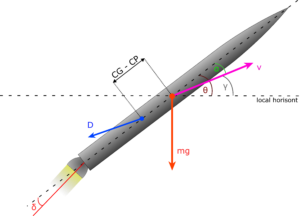

#### 2.1 - Translational Equations
##### Longitudinal axis (x):
$\dot{u} = \frac{1}{m} \left(T\cos{\delta_{TVC}} + L_c \sin{\alpha} - D_c\cos{\alpha} + L\sin{\alpha} - D\cos{\alpha}\right) - g\sin{\gamma} + qv$
##### Vertical axis (y):
$\dot{v} = \frac{1}{m} \left( T\sin{\delta_{TVC}} - L_c \cos{\alpha} - D_c\cos{\alpha} - L\sin{\alpha} - D\cos{\alpha}\right) + g\cos{\gamma} + qu$

##### Kinematic relations:
$\dot{x} = u\cos{\gamma} - v\sin{\gamma},\ \ \dot{y} = - u\sin{\gamma}  -v\cos{\gamma}$

#### 2.2 - Rotational Dynamics
##### Canard Moment generated by drag:
$M_c = D_c \cdot d_c$

##### Pitch rate $(q)$:
$\dot{q} = \frac{1}{I} \left( M_{TVC} + M_{L_c} + M_a - M_{D_c} \right)$
##### Pitch angle $(\theta)$: 
$\dot{\theta} = q$

#### 2.3 - Kinematic Equations
##### Horizontal position $(x)$:
$\dot{x} = u\cos{\theta} - v\sin{\theta}$
##### Vertical position $(y)$:
$\dot{y} = u\sin{\theta} + v\cos{\theta}$

#### 2.4 - Forces and Moments Definitions
##### Thrust Force Components:
$T\cos{\delta_T}, \ \ T\sin{\delta_T}, \\
M_T = T\sin{\delta_T}\cdot d_{T} $
##### Canard Lift and Drag:
$F_{D_c} = \frac{1}{2}\rho V^2S_cC_{D_c}, \ F_{L_c} = \frac{1}{2}\rho V^2S_cC_{L_c} \\
M_{L_c} = F_{L_c} \cdot d_c, \ M_{D_c} = F_{D_c} \cdot d_c $
##### Body Aerodynamic Forces:
$L = \frac{1}{2}\rho V^2S_cC_{L}, \ D = \frac{1}{2}\rho V^2S_cC_{D} $
##### Aerodynamic Pitching Moment:
$M_a = \frac{1}{2}\rho V^2S_c C_{m} c$

### 3 - State Space Model

#### 3.1 - Nominal Model
The nominal model is:  
$\dot{x} = Ax + Bu_{in}$  
where $x \ = \ [u,v,q,\theta,x,y]^{T} \ , \ u_{in} = [T, \delta_T, \alpha]^{T}$